# Metadata Extraction and Analysis

## Imports and dataloading

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm

# Statistical imports
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

from utils import *

In [2]:
import sys
sys.path.append('/users/wojemann/iEEG_processing')
from pioneer import Pioneer

In [11]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = \
load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'),'CHOP')

In [12]:
patient_table

ptID                                      ieeg_ids  lf_stim  hf_stim  \
0   CHOP005                       [CHOPCCEP_005, CHOP005]        1        0   
1   CHOP010  [CHOPCCEP_010, CHOP010a, CHOP010b, CHOP010c]        1        0   
2   CHOP024                       [CHOPCCEP_024, CHOP024]        1        0   
3   CHOP026                       [CHOPCCEP_026, CHOP026]        1        0   
4   CHOP028                       [CHOPCCEP_028, CHOP028]        1        0   
5   CHOP032                       [CHOPCCEP_032, CHOP032]        1        0   
6   CHOP035                       [CHOPCCEP_035, CHOP035]        1        0   
7   CHOP037                       [CHOPCCEP_037, CHOP037]        1        0   
8   CHOP038                       [CHOPCCEP_038, CHOP038]        1        0   
9   CHOP041                       [CHOPCCEP_041, CHOP041]        1        1   
10  CHOP044                       [CHOPCCEP_044, CHOP044]        1        0   
11  CHOP045                       [CHOPCCEP_045, CHOP045]        1        0   
12  CHOP046                       [CHOPCCEP_046, CHOP046]        1        0   
13  CHOP049                       [CHOPCCEP_049, CHOP049]        1        0   

    typical  mtle  focality  laterality   interictal_training  
0       NaN   NaN       NaN         NaN   [CHOP005, 14190.17]  
1       NaN   NaN       NaN         NaN                    []  
2       NaN   NaN       NaN         NaN  [CHOP024, 112138.27]  
3       NaN   NaN       NaN         NaN   [CHOP026, 76411.33]  
4       NaN   NaN       NaN         NaN    [CHOP028, 7517.56]  
5       NaN   NaN       NaN         NaN    [CHOP032, 18675.0]  
6       NaN   NaN       NaN         NaN    [CHOP035, 82282.0]  
7       NaN   NaN       NaN         NaN   [CHOP037, 58173.01]  
8       NaN   NaN       NaN         NaN                    []  
9       NaN   NaN       NaN         NaN   [CHOP041, 112959.7]  
10      NaN   NaN       NaN         NaN    [CHOP044, 4070.79]  
11      NaN   NaN       NaN         NaN   [CHOP045, 13156.41]  
12      NaN   NaN       NaN         NaN                    []  
13      NaN   NaN       NaN         NaN    [CHOP049, 8313.95]

## Creating annotation assignments

In [ ]:
seizures_df = pd.read_csv(ospj(metapath,'stim_seizure_information - LF_seizure_annotation.csv'))
seizures_df = seizures_df[~seizures_df.Patient.isin(["HUP235","HUP238","HUP246","HUP261"])]
seizures_df = seizures_df[seizures_df['to_annotate']==1]
seizures_df['annotators'] = ""
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
seizures_df = seizures_df.drop(['to_annotate','Notes','source','EEC onset channels','UEO onset channels','EEC','UEO','Other_onset_description'],axis=1).reset_index(drop=True)
seizures_df.head()

Patient        IEEGname  approximate_onset        end  stim stim_channels  \
0  HUP224  HUP224_phaseII         71156.5900   71190.99   1.0       LB1-LB2   
1  HUP224  HUP224_phaseII        339143.6435  339234.20   0.0           NaN   
2  HUP224  HUP224_phaseII        491467.8046  491541.43   0.0           NaN   
3  HUP224  HUP224_phaseII        519177.9500  519258.16   0.0           NaN   
4  HUP225  HUP225_phaseII        159834.1400  159913.05   1.0       RC1-RC2   

   typical  LVFA  Summaries annotators  
0      0.0   0.0      456.0             
1      NaN   NaN        NaN             
2      NaN   NaN        NaN             
3      NaN   NaN        NaN             
4      1.0   0.0        NaN

In [6]:
# Assuming you have a DataFrame named 'seizures_df' containing seizure data
# And a list of annotators initials 2,5
np.random.seed(10)
annotators = ['CK','EC','DZ','JJ','JK']
annotation_counts = {key: 0 for key in annotators}
def calc_weights(annotation_counts):
    weights = [1/(1+value) for value in annotation_counts.values()]
    tot_weight = sum(weights)
    return [w/tot_weight for w in weights]

# Assuming 'seizures_df' contains a column 'patient_id' indicating the patient ID for each seizure
# We'll first group seizures by patient_id
grouped_seizures = seizures_df.groupby('Patient')

# Dictionary to store DataFrames for each annotator
annotator_dfs = {}

# Create Primary DF that contains all seizures from all patients with all annotators per seizure
# Iterate over each patient group
for patient_id, patient_group in grouped_seizures:
    num_seizures = len(patient_group)
    # Randomly assign 3 annotators to the patient
    weights = calc_weights(annotation_counts)
    assigned_annotators = np.random.choice(annotators, size=3, replace=False,p=weights)
    annot_str = str(assigned_annotators)
    
    annotator_list = np.repeat(annot_str,num_seizures,0)
    # if len(annotator_list.shape) < 2:
    #     annotator_list = np.expand_dims(annotator_list,0)
    
    seizures_df.iloc[seizures_df.Patient == patient_id,-1] = annotator_list
    # Repeat the annotators for each seizure in the patient group
    for annotator in assigned_annotators:
        annotation_counts[annotator] += len(patient_group)
        if annotator in annotator_dfs.keys():
            annotator_dfs[annotator] = pd.concat([annotator_dfs[annotator],patient_group])
        else:
            annotator_dfs[annotator] = patient_group
print(annotation_counts)

{'CK': 34, 'EC': 42, 'DZ': 33, 'JJ': 35, 'JK': 36}


In [18]:
for key in annotator_dfs.keys():
    annotator_dfs[key][["UEO_time","UEO_ch","10sec_ch"]] = ""
    annotator_dfs[key].to_csv(ospj(prodatapath,f"stim_seizure_annotations_{key}.csv"),index=False)
seizures_df.to_csv(ospj(prodatapath,"LF_seizure_annotations_wannotator.csv"),index=False)

## Extracting seizure annotations from iEEG

In [13]:
# for i,pt in patient_table.iloc[[-2],:].iterrows():
for i,pt in patient_table[patient_table.ptID == 'CHOP032'].iterrows():
    for ieeg_pt in pt.ieeg_ids:
        # try:
            save_path = ospj(datapath,pt.ptID)
            print(ieeg_pt,save_path)
            if not ospe(save_path):
                os.makedirs(save_path)
            wagon = Pioneer(usr,passpath,ieeg_pt)
            wagon.pull_annotations()
            wagon.filter_seizure_annotations()
            wagon.seizure_annotations.to_csv(ospj(save_path,f'seizure_annotations_{ieeg_pt}.csv'))
        # except:
        #     continue

CHOPCCEP_032 /mnt/sauce/littlab/users/wojemann/stim-seizures/RAW_DATA/CHOP032
got 100 annotations on call # 1 covering 22925780761 usec to 25072323242 usec
got 100 annotations on call # 2 covering 25073326171 usec to 25969639160 usec
got 100 annotations on call # 3 covering 25971192871 usec to 26801372070 usec
got 100 annotations on call # 4 covering 26802388671 usec to 27668140625 usec
got 100 annotations on call # 5 covering 27673568847 usec to 28484145996 usec
got 100 annotations on call # 6 covering 28485167480 usec to 29377541015 usec
got 100 annotations on call # 7 covering 29377543945 usec to 30479178711 usec
got 100 annotations on call # 8 covering 30481079589 usec to 31405335937 usec
got 72 annotations on call # 9 covering 31520166015 usec to 33032063964 usec
Filtered       9.97% of all annotations
CHOP032 /mnt/sauce/littlab/users/wojemann/stim-seizures/RAW_DATA/CHOP032
got 100 annotations on call # 1 covering 49212890 usec to 32032358398 usec
got 100 annotations on call # 2 c

## StimSz metadata analysis

In [ ]:
metadata_table = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata.csv')).loc[:,["record_id","hupsubjno",
                                                                                            "Laterality","unifocal",
                                                                                            "localization","duration",
                                                                                            "outcome","lesional"]]
metadata_table['stim_sz'] = metadata_table['hupsubjno'].apply(int).isin(patient_table.ptID.apply(lambda x: int(x[3:])))
metadata_table['mtle'] = metadata_table.localization.apply(lambda x: 'MTLE' in x if not isinstance(x,float) else False)
# metadata_table['mtle'] = metadata_table.localization == 'MTLE'
metadata_table["unifocal"] = metadata_table.unifocal == 1
metadata_table["lesional"] = metadata_table.lesional == 1
metadata_table.loc[metadata_table.unifocal == 0,'mtle'] = pd.NA
metadata_table.head()

record_id  hupsubjno  Laterality  unifocal localization  duration  outcome  \
0        650        211         3.0     False         MTLE      11.3      NaN   
1        651        212         4.0     False          NaN      13.9      NaN   
2        649        213         1.0      True         MTLE      19.1      NaN   
3        652        214         3.0     False         MTLE       8.6      NaN   
4        658        216         1.0      True        Other      21.1      1.0   

   stim_sz   mtle  
0    False    NaN  
1    False    NaN  
2    False   True  
3    False    NaN  
4    False  False

In [10]:
for col in ["unifocal","mtle","outcome"]:
    data = metadata_table.loc[~metadata_table[col].isna(),:]
    cont_table = pd.crosstab(data[col],data["stim_sz"])
    print(cont_table)
    res = fisher_exact(cont_table)
    print(f"p-value: {res.pvalue}")
    _,p = proportions_ztest(data.loc[data.stim_sz,col].astype(bool).sum(),len(data[data.stim_sz]),0.5)
    print(f"Odds of category given stim_sz occured: {p}")
    print("\n")

stim_sz   False  True 
unifocal              
False        17      5
True         17     15
p-value: 0.09049958214789533
Odds of category given stim_sz occured: 0.009823274507519249


stim_sz  False  True 
mtle                 
False        7      4
True        10     11
p-value: 0.4719136399542166
Odds of category given stim_sz occured: 0.04099706113290014


stim_sz  False  True 
outcome              
0.0          4      3
1.0          5      4
p-value: 1.0
Odds of category given stim_sz occured: 0.7025494055759491




In [169]:
data = metadata_table[~metadata_table.duration.isna()]
# data = metadata_table[["unifocal","duration","stim_sz","mtle"]].dropna(how='any',axis=0)
y = data.stim_sz
# X = data.drop("stim_sz",axis=1).astype(float)
X = data[["duration"]]
X['constant'] = np.ones((len(X),),dtype=float)
model = sm.Logit(y,X).fit()
# print(f"p-value {model.pvalues['duration']}")
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.658832
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                stim_sz   No. Observations:                   54
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            1
Date:                Wed, 14 Aug 2024   Pseudo R-squ.:               0.0004858
Time:                        22:30:14   Log-Likelihood:                -35.577
converged:                       True   LL-Null:                       -35.594
Covariance Type:            nonrobust   LLR p-value:                    0.8525
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
duration      -0.0044      0.024     -0.186      0.853      -0.051       0.042
constant      -0.4624      0.

<Axes: xlabel='duration', ylabel='stim_sz'>

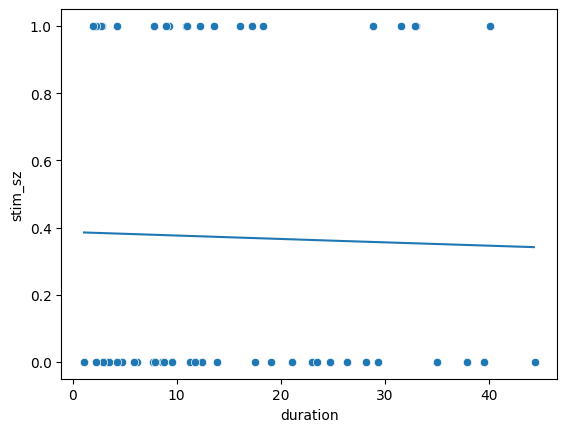

In [183]:
sns.scatterplot(x=data.duration,y=y)
x_plot = np.arange(data.duration.min(),data.duration.max(),.1)
sns.lineplot(x=x_plot,y=model.predict(np.concatenate((x_plot.reshape(-1,1),np.ones((len(x_plot),1))),axis=1)))